# Notebook to analyze the data from AGNs catalogs

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [260]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
from astropy.io import fits
from astropy.table import Table
from astropy.table import Column
from astropy.table import MaskedColumn
from astropy.table import hstack
from astropy.table import vstack
from astropy.table import join
# from astropy.wcs import WCS
from astropy import units as u
# from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
import getpass
import progressbar
import pandas as pd
from pandas.plotting import scatter_matrix
import re

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [184]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [185]:
alpha_used  = alpha_butl

In [186]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [187]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

---

## Reading data

In [188]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

In [189]:
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned.h5', 'df')  # Remember columns with 'Flux Density...' are in Jy (not mJy as the others)

In [190]:
large_catalog_tab = Table.from_pandas(large_catalog_df)

In [191]:
np.savetxt('column_names.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

In [192]:
large_catalog_df.columns[270:320]

Index(['NED Uncertainty 0.3-8 keV', 'Flux Density [O III]',
       'NED Uncertainty [O III]', 'Flux Density J_14arcsec',
       'NED Uncertainty J_14arcsec', 'Flux Density H_14arcsec',
       'NED Uncertainty H_14arcsec', 'Flux Density K_s_14arcsec',
       'NED Uncertainty K_s_14arcsec', 'Flux Density 4.99 GHz',
       'NED Uncertainty 4.99 GHz', 'Flux Density 2 keV',
       'NED Uncertainty 2 keV', 'Flux Density 24.0 microns',
       'NED Uncertainty 24.0 microns', 'Flux Density 0.15-3.5 keV',
       'NED Uncertainty 0.15-3.5 keV', 'Flux Density 100 microns Herschel',
       'NED Uncertainty 100 microns Herschel',
       'Flux Density 170 microns Herschel',
       'NED Uncertainty 170 microns Herschel', 'Flux Density 250 microns',
       'NED Uncertainty 250 microns', 'Flux Density 250 microns Herschel',
       'NED Uncertainty 250 microns Herschel',
       'Flux Density 350 microns Herschel',
       'NED Uncertainty 350 microns Herschel', 'Flux Density 500 microns',
       'NED Unce

In [193]:
large_catalog_df.loc[90:110, ['MAIN_ID_x', 'MAIN_ID_y']]

,MAIN_ID_x,MAIN_ID_y
90,SDSS J021954.62-054922.2,WISEA J021954.62-054922.3
91,SDSS J021657.68-054810.8,SDSS J021657.68-054810.8
92,SDSS J015116.48-054459.6,SDSS J015116.48-054459.6
93,SDSS J014817.84-054404.1,WISEA J014817.83-054404.0
94,3XLSS J020809.5-053838,WISEA J020809.62-053839.2
95,SDSS J013019.29-053812.0,SDSS J013019.29-053812.0
96,SDSS J024030.82-053741.2,WISEA J024030.79-053742.1
97,3XMM J022556.4-053451,WISEA J022556.38-053451.4
98,SDSS J004908.15-053137.3,NaN
99,SDSS J020721.38-052925.3,WISEA J020721.38-052927.0


---

## Organize data

Separate data into different arrays for calculations

Repeated keywords are: `MAIN_ID_x`, `MAIN_ID_y`, `COORD_x`, and `COORD_y`

In [194]:
redshift    = large_catalog_df['Z_OWN']
redshift_e  = large_catalog_df['Z_OWN_ERR']
L_20cm      = large_catalog_df['L_20CM']
L_20cm_e    = large_catalog_df['L_20CM_ERR']
L_20cm_up_l = large_catalog_df['L_20CM_UP_LIM']

In [195]:
large_catalog_df['L_20CM'].describe()

count    1.795700e+04
mean     4.736101e+26
std      2.727563e+27
min      9.646523e+15
25%      3.574307e+22
50%      8.950888e+23
75%      1.421476e+26
max      1.894966e+29
Name: L_20CM, dtype: float64

Calculate Luminosities from fluxes

In [196]:
numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
                                                                           'FLUX_ERROR_K', 'Z_OWN'])
#numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'D_LUM', 'FLUX_ERROR_B',\
#                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
#                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
#                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
#                                                                           'FLUX_ERROR_K', 'JOINED_F_14GHZ', 'TEST_14_LUM',\
#                                                                           'Z_OWN'])

In [197]:
lums_catalog_df = pd.DataFrame()

In [198]:
for col_name in numeric_col_names:
    if 'F_' in col_name:
        lum_col_name = col_name.replace('F_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'FLUX_' in col_name:
        lum_col_name = col_name.replace('FLUX_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'Flux Density' in col_name:
        lum_col_name = col_name.replace('Flux Density', 'Luminosity')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name] * 1e3, redshift)
    

In [199]:
lums_catalog_df.describe()

,LUMINOSITY_B,LUMINOSITY_V,LUMINOSITY_R,LUMINOSITY_I,LUMINOSITY_J,LUMINOSITY_K,LUMINOSITY_20CM,LUMINOSITY_250GHZ,Luminosity u,Luminosity g,...,Luminosity 203.850 GHz,Luminosity 163.088 GHz,Luminosity 81.551 GHz,Luminosity [OII] 3727,Luminosity [NeIII] 3869 VIRUS-P,Luminosity [OIII] 5007 VIRUS-P,Luminosity 890 microns,Luminosity 1.1 mm,Luminosity 345 GHz,Luminosity 830 A
count,9.062000e+03,9.166000e+03,5.540000e+03,5.856000e+03,6.575000e+03,8.102000e+03,1.795700e+04,1.300000e+01,1.002100e+04,1.005700e+04,...,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,8.000000e+00,1.600000e+01,1.000000e+00,2.000000e+00
mean,3.924400e+26,3.904244e+26,2.991545e+26,2.784247e+26,3.158351e+26,2.849575e+26,4.736151e+26,4.417714e+26,4.457645e+23,8.902164e+23,...,2.067884e+26,1.495651e+26,5.490590e+25,1.272873e+34,8.900665e+33,2.750461e+33,7.220018e+26,2.524663e+26,1.305538e+27,9.512274e+19
std,5.616629e+26,5.507334e+26,4.641261e+26,4.332300e+26,4.947404e+26,4.445087e+26,2.727592e+27,6.398424e+26,1.107670e+24,1.963771e+24,...,NaN,NaN,NaN,6.662592e+33,NaN,NaN,6.030766e+26,2.861560e+26,NaN,1.055127e+20
min,2.481603e+19,2.408491e+19,1.230887e+21,1.206755e+21,2.100716e+19,1.903031e+19,9.729832e+15,1.807785e+25,-3.747647e+23,-1.448245e+23,...,2.067884e+26,1.495651e+26,5.490590e+25,2.241848e+33,8.900665e+33,2.750461e+33,1.313110e+26,1.086765e+25,1.305538e+27,2.051399e+19
25%,5.168651e+25,5.048963e+25,4.108447e+25,3.817570e+25,3.932664e+25,3.667255e+25,3.574437e+22,5.147963e+25,1.539045e+22,4.481700e+22,...,2.067884e+26,1.495651e+26,5.490590e+25,7.719895e+33,8.900665e+33,2.750461e+33,3.814008e+26,8.021943e+25,1.305538e+27,5.781836e+19
50%,1.790516e+26,1.805278e+26,1.209533e+26,1.140024e+26,1.297888e+26,1.184217e+26,8.951111e+23,2.006259e+26,1.244598e+23,3.190944e+23,...,2.067884e+26,1.495651e+26,5.490590e+25,1.282739e+34,8.900665e+33,2.750461e+33,5.139162e+26,1.559782e+26,1.305538e+27,9.512274e+19
75%,5.486562e+26,5.519792e+26,3.705031e+26,3.440732e+26,4.071034e+26,3.692562e+26,1.421496e+26,4.604034e+26,4.228775e+23,9.404684e+23,...,2.067884e+26,1.495651e+26,5.490590e+25,1.464847e+34,8.900665e+33,2.750461e+33,8.375288e+26,3.486199e+26,1.305538e+27,1.324271e+20
max,7.025390e+27,6.919378e+27,5.719435e+27,6.749024e+27,5.487844e+27,5.777004e+27,1.894982e+29,2.332115e+27,2.654041e+25,6.499320e+25,...,2.067884e+26,1.495651e+26,5.490590e+25,2.670200e+34,8.900665e+33,2.750461e+33,1.916053e+27,1.142262e+27,1.305538e+27,1.697315e+20


---

## Plot initial values

In [200]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [201]:
lum_FIRST   = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_50uJy   = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_20uJy   = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_10uJy   = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_5uJy    = 4 * np.pi * lum_dist_range**2 * 5e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_1uJy    = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

In [202]:
cmap        = cm.get_cmap('inferno')
dark_color  = cmap(0.4)  # RGBA color code
light_color = cmap(0.6)  # RGBA color code
colors      = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8    = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [203]:
pe1 = [mpe.Stroke(linewidth=3, foreground='black'),
       mpe.Stroke(foreground='white', alpha=1),
       mpe.Normal()]

alp_str     = r'$\alpha$'

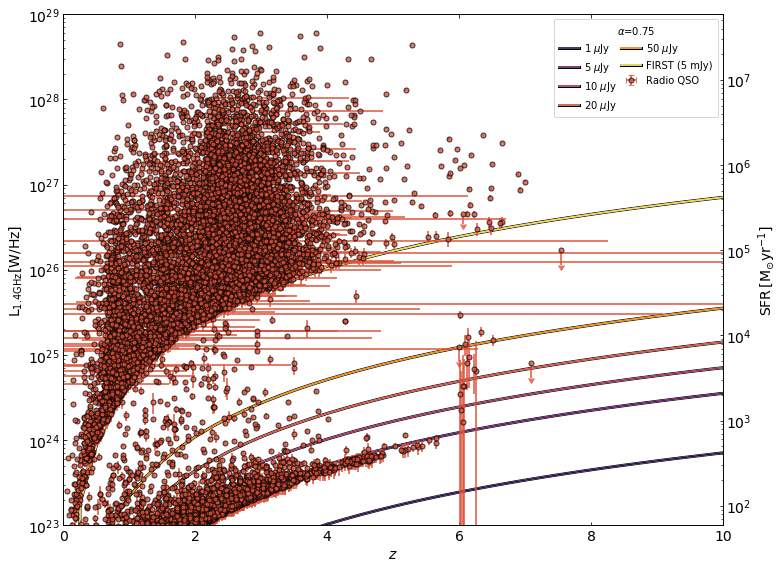

In [204]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.errorbar(redshift, L_20cm, xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')

#ax1.errorbar(high_z_zs[filter_250GHz], lum_250_new_alpha_rescale[filter_250GHz], yerr=lum_250_new_alpha_rescale_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')

ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
ax1.plot(z_range, lum_5uJy, label='5 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[2], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[4], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST (5 mJy)', color=colors[5], path_effects=pe1)
#ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
#ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
#gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
#gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=5.5, right=8)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


ax2 = ax1.twinx()
ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
ax2.set_yscale('log')
ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

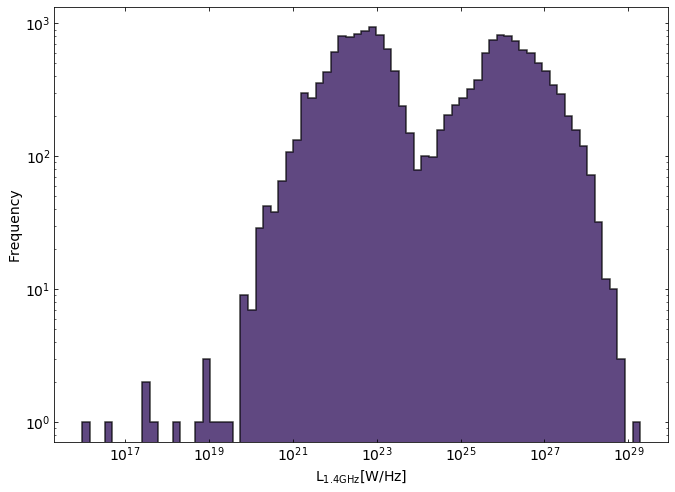

In [205]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

vmin_L = np.log10(large_catalog_df['L_20CM'].min())
vmax_L = np.log10(large_catalog_df['L_20CM'].max())
bins_L = np.logspace(vmin_L, vmax_L, 75)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
large_catalog_df['L_20CM'].plot.hist(color=colors[0], alpha=0.75, bins=bins_L, histtype='stepfilled', ec='k', lw=1.5)

In [206]:
large_catalog_df['D_LUM'] = cosmo.luminosity_distance(large_catalog_df['Z_OWN']).to(u.m).value

In [207]:
large_catalog_df['D_LUM'].describe()

count    1.802300e+04
mean     4.195262e+26
std      2.826959e+26
min      1.321621e+22
25%      1.792321e+26
50%      3.732220e+26
75%      6.120989e+26
max      2.321301e+27
Name: D_LUM, dtype: float64

In [208]:
large_catalog_df['JOINED_F_14GHZ'] = (large_catalog_df[['Flux Density 1.4GHz', 'Flux Density 1.40 GHz',\
                                'Flux Density 1.4 GHz', 'Flux Density 1420.5 MHz',\
                                'Flux Density 1.42 GHz', 'Flux Density 1425 MHz',\
                                'Flux Density 1410 MHz', 'Flux Density 1.4 GHz VLA B-array']].mean(axis=1) * 1e3 + large_catalog_df['F_20CM']) / 2

In [209]:
large_catalog_df['JOINED_F_14GHZ'].describe()

count     6096.000000
mean        47.445537
std        250.872597
min          0.014802
25%          0.086779
50%          4.445000
75%         31.248750
max      14803.876617
Name: JOINED_F_14GHZ, dtype: float64

In [210]:
joined_lum_14GHz = lum_from_flux(large_catalog_df['JOINED_F_14GHZ'], redshift)

In [211]:
joined_lum_14GHz.describe()

count    6.096000e+03
mean     1.178639e+27
std      4.548202e+27
min      6.199880e+16
25%      6.579657e+23
50%      8.572212e+25
75%      7.858036e+26
max      1.901070e+29
dtype: float64

In [212]:
large_catalog_df[['Flux Density 1.4GHz', 'Flux Density 1.40 GHz',\
                                'Flux Density 1.4 GHz', 'Flux Density 1420.5 MHz',\
                                'Flux Density 1.42 GHz', 'Flux Density 1425 MHz',\
                                'Flux Density 1410 MHz', 'Flux Density 1.4 GHz VLA B-array']].describe()

,Flux Density 1.4GHz,Flux Density 1.40 GHz,Flux Density 1.4 GHz,Flux Density 1420.5 MHz,Flux Density 1.42 GHz,Flux Density 1425 MHz,Flux Density 1410 MHz,Flux Density 1.4 GHz VLA B-array
count,3483.000000,228.000000,2537.000000,1.0,1.0000,3.000000,43.000000,1.0000
mean,0.057922,0.397746,0.010883,14.7,0.0324,0.016333,1.394419,0.0473
std,0.279210,0.603194,0.090422,NaN,NaN,0.003580,2.453546,NaN
min,0.000520,0.096000,0.000025,14.7,0.0324,0.012400,0.260000,0.0473
25%,0.005900,0.166000,0.000069,14.7,0.0324,0.014800,0.545000,0.0473
50%,0.022000,0.249000,0.000129,14.7,0.0324,0.017200,0.700000,0.0473
75%,0.050700,0.413000,0.000285,14.7,0.0324,0.018300,1.200000,0.0473
max,14.900000,7.890000,3.070000,14.7,0.0324,0.019400,14.900000,0.0473


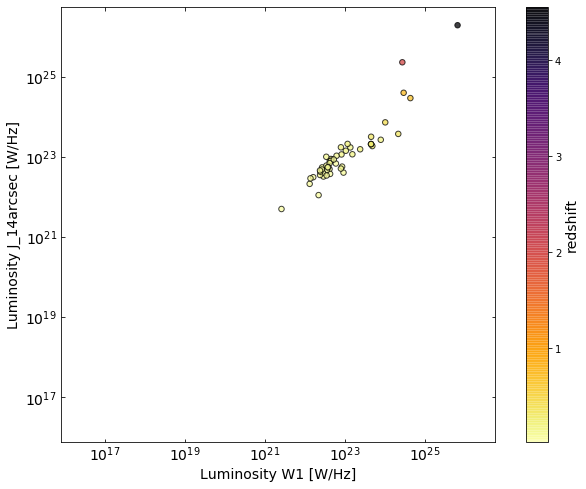

In [213]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

col_a = "Flux Density W1"
col_b = "Flux Density J_14arcsec"

if 'Flux Density' in col_a:
    flx_a = large_catalog_df[col_a] * 1e3
if 'Flux Density' in col_b:
    flx_b = large_catalog_df[col_b] * 1e3

if 'FLUX_' in col_a or 'F_' in col_a:
    flx_a = large_catalog_df[col_a]
if 'FLUX_' in col_b or 'F_' in col_b:
    flx_b = large_catalog_df[col_b]


lum_a = lum_from_flux(flx_a, redshift)
lum_b = lum_from_flux(flx_b, redshift)

ax1.set_yscale('log')
ax1.set_xscale('log')
min_val = np.nanmin([lum_a.min(), lum_b.min()])
max_val = np.nanmax([lum_a.max(), lum_b.max()])
if 'Flux Density' in col_a:
    ax1.set_xlabel(col_a.replace('Flux Density', 'Luminosity') + ' [W/Hz]', size=14)
if 'Flux Density' in col_b:
    ax1.set_ylabel(col_b.replace('Flux Density', 'Luminosity') + ' [W/Hz]', size=14)
if 'FLUX_' in col_a:
    ax1.set_xlabel(col_a.replace('FLUX_', 'Luminosity ') + ' [W/Hz]', size=14)
if 'FLUX_' in col_b:
    ax1.set_ylabel(col_b.replace('FLUX_', 'Luminosity ') + ' [W/Hz]', size=14)
if 'F_' in col_a:
    ax1.set_xlabel(col_a.replace('F_', 'Luminosity ') + ' [W/Hz]', size=14)
if 'F_' in col_b:
    ax1.set_ylabel(col_b.replace('F_', 'Luminosity ') + ' [W/Hz]', size=14)
ax1.set_ylim(min_val, max_val)
ax1.set_xlim(min_val, max_val)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.plot(lum_a, lum_b, '.', color=colors[1])
sc  = ax1.scatter(lum_a, lum_b, c=redshift, cmap='inferno_r', s=30, alpha=0.75, edgecolor='black')
clb = plt.colorbar(sc)
clb.set_label('redshift', size=14)
ax1.set_aspect('equal')

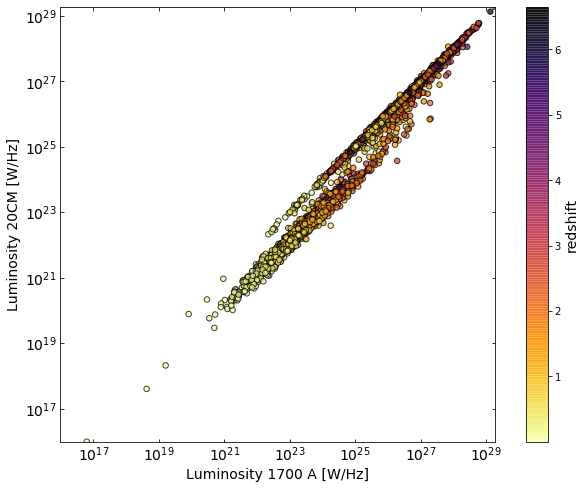

In [214]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

col_a = "Flux Density 1700 A"
col_b = "F_20CM"

if 'Flux Density' in col_a:
    flx_a = large_catalog_df[col_a] * 1e3
if 'Flux Density' in col_b:
    flx_b = large_catalog_df[col_b] * 1e3

if 'FLUX_' in col_a or 'F_' in col_a:
    flx_a = large_catalog_df[col_a]
if 'FLUX_' in col_b or 'F_' in col_b:
    flx_b = large_catalog_df[col_b]


lum_a = lum_from_flux(flx_a, redshift)
lum_b = lum_from_flux(flx_b, redshift)

ax1.set_yscale('log')
ax1.set_xscale('log')
min_val = np.nanmin([joined_lum_14GHz.min(), lum_b.min()])
max_val = np.nanmax([joined_lum_14GHz.max(), lum_b.max()])
if 'Flux Density' in col_a:
    ax1.set_xlabel(col_a.replace('Flux Density', 'Luminosity') + ' [W/Hz]', size=14)
if 'Flux Density' in col_b:
    ax1.set_ylabel(col_b.replace('Flux Density', 'Luminosity') + ' [W/Hz]', size=14)
if 'FLUX_' in col_a:
    ax1.set_xlabel(col_a.replace('FLUX_', 'Luminosity ') + ' [W/Hz]', size=14)
if 'FLUX_' in col_b:
    ax1.set_ylabel(col_b.replace('FLUX_', 'Luminosity ') + ' [W/Hz]', size=14)
if 'F_' in col_a:
    ax1.set_xlabel(col_a.replace('F_', 'Luminosity ') + ' [W/Hz]', size=14)
if 'F_' in col_b:
    ax1.set_ylabel(col_b.replace('F_', 'Luminosity ') + ' [W/Hz]', size=14)
ax1.set_ylim(min_val, max_val)
ax1.set_xlim(min_val, max_val)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
sc  = ax1.scatter(joined_lum_14GHz, lum_b, c=redshift, cmap='inferno_r', s=30, alpha=0.75, edgecolor='black')
clb = plt.colorbar(sc)
clb.set_label('redshift', size=14)
ax1.set_aspect('equal')

---

# Run clustering algorithms

Run clustering algorithms to try to find correlations and groups in our data.

In [215]:
num_of_cols = 18023
corr        = large_catalog_df[numeric_col_names[:num_of_cols]].corr(min_periods=20)
corr_abs    = corr.abs()
#corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
#corr.columns = ['x', 'y', 'value']

In [216]:
cols_corr = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

In [217]:
corr.iloc[0:8, 0:8]

,FLUX_B,FLUX_V,FLUX_R,FLUX_I,FLUX_J,FLUX_K,F_20CM,F_250GHZ
FLUX_B,1.000000,0.983362,0.949590,0.884474,0.887522,0.843326,-0.155472,NaN
FLUX_V,0.983362,1.000000,0.985288,0.950173,0.925764,0.882499,-0.154486,NaN
FLUX_R,0.949590,0.985288,1.000000,0.982684,0.930323,0.893078,-0.289321,NaN
FLUX_I,0.884474,0.950173,0.982684,1.000000,0.959702,0.923489,-0.066316,NaN
FLUX_J,0.887522,0.925764,0.930323,0.959702,1.000000,0.978354,-0.131514,NaN
FLUX_K,0.843326,0.882499,0.893078,0.923489,0.978354,1.000000,-0.139806,NaN
F_20CM,-0.155472,-0.154486,-0.289321,-0.066316,-0.131514,-0.139806,1.000000,NaN
F_250GHZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
arr_cols = np.array([np.array(row) for row in sol.keys()[sol<0.85][:25]])

In [219]:
np.shape(arr_cols)

(25, 2)

In [220]:
np.shape(np.unique(arr_cols[:, 1]))

(22,)

In [247]:
cols_high_corr = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))

In [222]:
sol[sol<0.75][:25]

Flux Density W1           Flux Density J_14arcsec      0.749620
FLUX_I                    Flux Density [N II] 6584     0.749246
Flux Density 8.4 GHz      Flux Density 22 microns      0.749031
Flux Density W3           Flux Density 103a-E          0.748557
Flux Density W4           Flux Density 103a-O          0.748035
Flux Density 250 microns  Flux Density 70 microns      0.747920
FLUX_B                    Flux Density 1700 A          0.747675
Flux Density 4.5 microns  Flux Density i+              0.747324
Flux Density g            Flux Density z               0.747312
Flux Density i            Flux Density 0.5-10 keV      0.747273
FLUX_J                    Flux Density I               0.746730
Flux Density I            Flux Density F814W           0.746708
Flux Density r            Flux Density [Fe II] 4570    0.745780
Flux Density z            Flux Density R               0.745566
Flux Density W3           Flux Density R               0.745482
Flux Density J            Flux Density 0

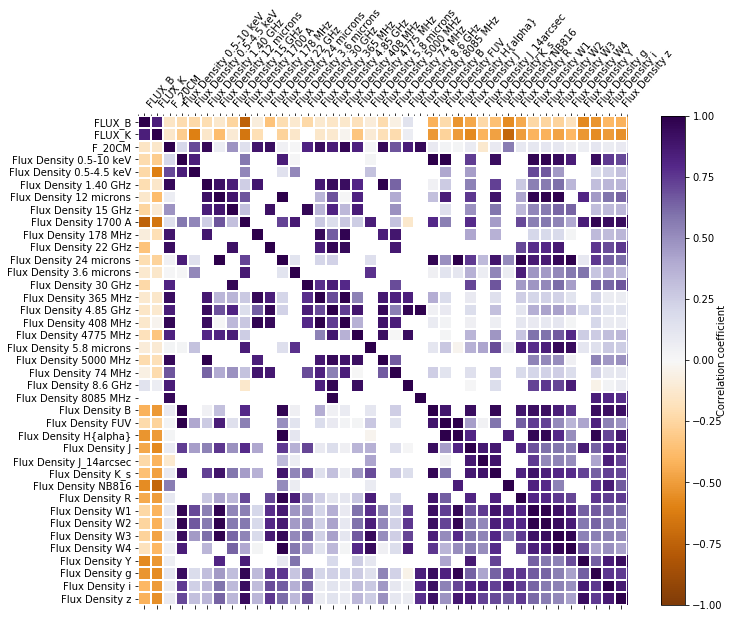

In [292]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# cax = ax1.matshow(corr.iloc[init_idx:end_idx, init_idx:end_idx],cmap='PuOr', vmin=-1, vmax=1)
cax = ax1.matshow(corr.loc[cols_high_corr, cols_high_corr],cmap='PuOr', vmin=-1, vmax=1)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel(cbarlabel, va="bottom")

for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(cols_high_corr.tolist()),1)
ax1.set_xticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr, rotation=50, horizontalalignment='left')
ax1.set_yticklabels(cols_high_corr)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax1.tick_params(which="minor", bottom=False, left=False)

ax1.set_aspect('equal')